# Proyecto Final

## Model Training

Importar librerías

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Carpetas de imágenes separadas por categoría

In [2]:
ls "Datasets/Food Dataset/"

Bebibas/  Snacks/  dataset_info.csv


Carga el dataset con la información de las imágenes

In [3]:
path = "Datasets/Food Dataset/"
info = "dataset_info.csv"
df = pd.read_csv(path+info)
df.head()

,image name,type,Descripción,Category,Material,Precio (Colones)
0,744100161906,jpg,Jugo Dos Pinos Naranja 100% Natural - 1800 ml,Bebibas,Botella de plástico,2595
1,744107412727,jpg,Agua De Pipa – 1800 ml,Bebibas,Botella de plástico,4100
2,1630016574,jpg,Jugo Florida Natural Naranja No Pulp – 2630 ml,Bebibas,Botella de plástico,6650
3,4850020277,jpg,Jugo Naranja Con Calcio Tropicana – 1530 ml,Bebibas,Botella de plástico,3550
4,744107411249,jpg,Agua De Pipa – 8 oz,Bebibas,Botella de plástico,900


Número de muestras por categoría

In [4]:
categories = np.unique(df['Category'],return_counts=True)
category_names = categories[0]
category_count = categories[1]
for i,c in enumerate(category_names): print(c," : ",category_count[i])

Bebibas  :  199
Snacks  :  199


Número de muestras por tipo de material

In [5]:
materials = np.unique(df['Material'],return_counts=True)
material_names = materials[0]
material_count = materials[1]
for i,m in enumerate(material_names): print(m," : ",material_count[i])

Bolsa Aluminio  :  149
Bolsa plástico  :  44
Botella de plástico  :  139
Botella de vidrio  :  1
Lata de aluminio  :  7
Paquete plástico  :  3
Tarro Cartón  :  3
Tetra brick  :  52


Mostrar imagen

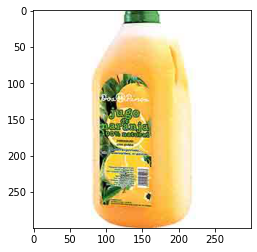

rows: 300 columns: 300 channels: 3


In [6]:
filecategory = df['Category'][0]
filename = df['image name'][0]
filetype = df['type'][0]
file = path+filecategory+"/"+str(filename)+"."+filetype
image = keras.preprocessing.image.load_img(file)
plt.imshow(image)
plt.show()
rows,columns,channels = np.array(image).shape
print("rows:",rows,"columns:",columns,"channels:",channels)

Mostrar imagen redimensionada

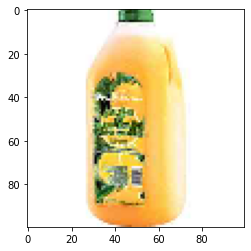

rows: 100 columns: 100 channels: 3


In [7]:
filecategory = df['Category'][0]
filename = df['image name'][0]
filetype = df['type'][0]
file = path+filecategory+"/"+str(filename)+"."+filetype
image = keras.preprocessing.image.load_img(file)
image_array = keras.preprocessing.image.img_to_array(image)
image_array = keras.preprocessing.image.smart_resize(image_array,(100,100),interpolation='bilinear')
image_array = image_array/255
plt.imshow(image_array)
plt.show()
rows,columns,channels = np.array(image_array).shape
print("rows:",rows,"columns:",columns,"channels:",channels)

Importar las imágenes de *testing* y realizar el preprocesado

In [8]:
samples = len(df)
Features = np.zeros((samples,rows,columns,channels))
Targets = np.unique(df['Category'],return_inverse=True)[1]

filecategories = df['Category']
filenames = df['image name']
filetypes = df['type']

for i,filecategory in enumerate(filecategories):
    file = path+filecategory+"/"+str(filenames[i])+"."+filetypes[i]
    image = keras.preprocessing.image.load_img(file)
    image_array = keras.preprocessing.image.img_to_array(image)
    image_array = keras.preprocessing.image.smart_resize(image_array,(rows,columns),interpolation='bilinear')
    Features[i,:,:,:] = image_array
    
Features = Features.astype('float32')
Features = Features/255

Desplegar las dimensiones del *set*

In [9]:
print(Features.shape)
print(Targets.shape)
print(np.unique(Targets,return_counts=True))

(398, 100, 100, 3)
(398,)
(array([0, 1]), array([199, 199]))


Número de categorías y conversión a vector binario

In [10]:
#set number of categories
num_category = 2
# convert class vectors to binary class matrices
Targets = keras.utils.to_categorical(Targets,num_category)

Dividir el *set* en *train* y *test*

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(Features,Targets,test_size = 0.2,random_state = 4)
print("Features:",Features.shape)
print("Targets:",Targets.shape)
#
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_test:",Y_test.shape)

Features: (398, 100, 100, 3)
Targets: (398, 2)
X_train: (318, 100, 100, 3)
X_test: (80, 100, 100, 3)
Y_train: (318, 2)
Y_test: (80, 2)


#### Modelo

In [12]:
input_shape = (rows,columns,channels)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_category, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               18874496  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Entrenamiento del modelo

In [13]:
batch_size = 100
num_epoch = 10
start = time.time()
model_log = model.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(X_test,Y_test))
end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print(f"Training time: {m} min / {s} sec")

Epoch 1/10
4/4 [==============================] - 13s 3s/step - loss: 0.7128 - accuracy: 0.4872 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 2/10
4/4 [==============================] - 11s 3s/step - loss: 0.7013 - accuracy: 0.5342 - val_loss: 0.6861 - val_accuracy: 0.6500
Epoch 3/10
4/4 [==============================] - 11s 3s/step - loss: 0.7154 - accuracy: 0.4603 - val_loss: 0.6792 - val_accuracy: 0.6000
Epoch 4/10
4/4 [==============================] - 12s 3s/step - loss: 0.6898 - accuracy: 0.5088 - val_loss: 0.6732 - val_accuracy: 0.6250
Epoch 5/10
4/4 [==============================] - 12s 3s/step - loss: 0.6881 - accuracy: 0.5404 - val_loss: 0.6758 - val_accuracy: 0.7000
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.7035 - accuracy: 0.4939 - val_loss: 0.6671 - val_accuracy: 0.7875
Epoch 7/10
4/4 [==============================] - 13s 3s/step - loss: 0.6759 - accuracy: 0.5540 - val_loss: 0.6668 - val_accuracy: 0.7750
Epoch 8/10
4/4 [==================

Accuracy & Loss plots

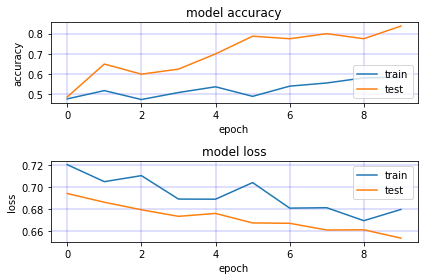

In [14]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid(color='b', linestyle='-', linewidth=0.25)

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(color='b', linestyle='-', linewidth=0.25)

plt.tight_layout()
plt.show()

Realizar el *training* con todo el *dataset*

In [15]:
start = time.time()
model_log = model.fit(Features,Targets,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1)
end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print(f"Training time: {m} min / {s} sec")

Epoch 1/10
4/4 [==============================] - 13s 3s/step - loss: 0.6689 - accuracy: 0.5829
Epoch 2/10
4/4 [==============================] - 16s 4s/step - loss: 0.6618 - accuracy: 0.6030
Epoch 3/10
4/4 [==============================] - 16s 4s/step - loss: 0.6665 - accuracy: 0.6156
Epoch 4/10
4/4 [==============================] - 16s 4s/step - loss: 0.6542 - accuracy: 0.6457
Epoch 5/10
4/4 [==============================] - 17s 4s/step - loss: 0.6448 - accuracy: 0.6558
Epoch 6/10
4/4 [==============================] - 16s 4s/step - loss: 0.6442 - accuracy: 0.6683
Epoch 7/10
4/4 [==============================] - 16s 4s/step - loss: 0.6316 - accuracy: 0.6884
Epoch 8/10
4/4 [==============================] - 17s 4s/step - loss: 0.6541 - accuracy: 0.6407
Epoch 9/10
4/4 [==============================] - 17s 4s/step - loss: 0.6375 - accuracy: 0.6784
Epoch 10/10
4/4 [==============================] - 16s 4s/step - loss: 0.6459 - accuracy: 0.6307
Training time: 2.66 min / 159.62 sec


Guardar el modelo

In [16]:
model.save("food_classifier_model.h5")